### CONFIGURATION

In [28]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('max_colwidth',200)  #necessary for pileup files

In [29]:
# Hartwig imports
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import analyseVCF as aVCF
import analysePileup as aPILEUP
import venn as vn

In [30]:
#CHROM SLICING
minChromFrac = 17.443476
maxChromFrac = 17.491846
#minChromFrac = 17.689695
#maxChromFrac = 17.73896
#minChromFrac = 0
#maxChromFrac = 26

In [31]:
# COMBINED VCF CONFIG
VCF_SAMPLE = "CPCT02010306"
VCF_PATH = "/Users/peterpriestley/hmf/analyses/cancerSample/"
VCF_FILE_NAME = VCF_SAMPLE + "R_" + VCF_SAMPLE + "T_merged_somatics.vcf"
SAMPLE_NAMES = {VCF_SAMPLE + 'T.mutect':'mutect', \
                VCF_SAMPLE + 'T.freebayes':'freebayes', \
                'TUMOR.strelka':'strelka', \
                'TUMOR.varscan':'varscan'}
# PILEUP CONFIG
PILEUP_PATH = "/Users/peterpriestley/hmf/slice" + VCF_SAMPLE + "/"
NORMAL_PILEUP_FILENAME = VCF_SAMPLE + ".pileup"
TUMOR_PILEUP_FILENAME = VCF_SAMPLE + "T.pileup"

<h3> Load VCFs and Prepare DF

In [32]:
# LOAD PROD VCF and filter
df = aVCF.loadVaraintsFromVCF(VCF_PATH,VCF_FILE_NAME,SAMPLE_NAMES,VCF_SAMPLE,True,False)#True,sampleBed)
df = df[(df.chromFrac > minChromFrac)&(df.chromFrac < maxChromFrac)]


reading vcf file: CPCT02010306R_CPCT02010306T_merged_somatics.vcf
Number variants loaded: 69901


<h3> SLICE ANALYSIS

In [33]:
# SLICE SETTINGS
SLICE_VCF_PATH = "/Users/peterpriestley/hmf/slice" + VCF_SAMPLE + "/"
SLICE_VCF_FILE_NAME = "somatics.merged.vcf"
SLICE_SAMPLE_NAMES = SAMPLE_NAMES 
dfSlice = aVCF.loadVaraintsFromVCF(SLICE_VCF_PATH,SLICE_VCF_FILE_NAME,SLICE_SAMPLE_NAMES,VCF_SAMPLE,True,False)
dfSlice['Prod']=dfSlice.chromPos.isin(df['chromPos']) 
df['Slice']=df.chromPos.isin(dfSlice['chromPos']) 
dfSlice = dfSlice[(dfSlice.chromFrac > minChromFrac)&(dfSlice.chromFrac < maxChromFrac)]

reading vcf file: somatics.merged.vcf
Number variants loaded: 112


In [34]:
#INTERNAL 'PRECISION' + 'SENSITIVITY' per caller
outputdata = []
variantTypes = df.variantType.unique()
patientNames = df.patientName.unique()
for patientName in patientNames:
    for variantType in variantTypes:
        truthSet = len(df[(df['numCallers'] >= 2)&(df['variantType'] == variantType)&(df['patientName'] == patientName)])
        for columnName in list(df):
            if columnName.endswith('allele'):
                myCaller = columnName[:-6]
                truePositives = len(df[(df[myCaller+'allele'] != '')&(df['numCallers'] >=2) &\
                                   (df['variantType'] == variantType)&(df['patientName'] == patientName)])
                falseNegatives = len(df[(df[myCaller+'allele'] == '')&(df['numCallers'] >= 2) &\
                                    (df['variantType'] == variantType)&(df['patientName'] == patientName)])
                positives = len(df[(df[myCaller+'allele'] != '')&\
                                   (df['variantType'] == variantType)&(df['patientName'] == patientName)]) 
                if positives > 0 and truthSet > 0:
                    outputdata.append([patientName,variantType, myCaller, truthSet,truePositives,\
                                   positives-truePositives, falseNegatives, \
                                   round(truePositives/float(positives),4),round(truePositives/float(truthSet),4)])
                else:
                   outputdata.append([patientName,variantType, myCaller, truthSet,truePositives,\
                                   positives-truePositives, falseNegatives, \
                                   'na','na'])
outputDF = pd.DataFrame(outputdata)
outputDF.columns = (['patientName','variantType','caller','truth','TP','FP','FN',\
                     'intPrecision','intSensitivity'])
outputDF.sort_values(['patientName','variantType','caller'])

,patientName,variantType,caller,truth,TP,FP,FN,intPrecision,intSensitivity
7,CPCT02010306,INDEL,freebayes,0,0,2,0,na,na
6,CPCT02010306,INDEL,mutect,0,0,0,0,na,na
4,CPCT02010306,INDEL,strelka,0,0,0,0,na,na
5,CPCT02010306,INDEL,varscan,0,0,3,0,na,na
3,CPCT02010306,SNP,freebayes,13,3,14,10,0.1765,0.2308
2,CPCT02010306,SNP,mutect,13,13,17,0,0.4333,1
0,CPCT02010306,SNP,strelka,13,13,32,0,0.2889,1
1,CPCT02010306,SNP,varscan,13,10,1,3,0.9091,0.7692


In [35]:
#INTERNAL 'PRECISION' + 'SENSITIVITY' per caller - SLICE
outputdata = []
variantTypes = dfSlice.variantType.unique()
patientNames = dfSlice.patientName.unique()
for patientName in patientNames:
    for variantType in variantTypes:
        truthSet = len(dfSlice[(dfSlice['numCallers'] >= 2)&(dfSlice['variantType'] == variantType)&(dfSlice['patientName'] == patientName)])
        for columnName in list(dfSlice):
            if columnName.endswith('allele'):
                myCaller = columnName[:-6]
                truePositives = len(dfSlice[(dfSlice[myCaller+'allele'] != '')&(dfSlice['numCallers'] >=2) &\
                                   (dfSlice['variantType'] == variantType)&(dfSlice['patientName'] == patientName)])
                falseNegatives = len(dfSlice[(dfSlice[myCaller+'allele'] == '')&(dfSlice['numCallers'] >= 2) &\
                                    (dfSlice['variantType'] == variantType)&(dfSlice['patientName'] == patientName)])
                positives = len(dfSlice[(dfSlice[myCaller+'allele'] != '')&\
                                   (dfSlice['variantType'] == variantType)&(dfSlice['patientName'] == patientName)]) 
                if positives > 0 and truthSet > 0:
                    outputdata.append([patientName,variantType, myCaller, truthSet,truePositives,\
                                   positives-truePositives, falseNegatives, \
                                   round(truePositives/float(positives),4),round(truePositives/float(truthSet),4)])
                else:
                   outputdata.append([patientName,variantType, myCaller, truthSet,truePositives,\
                                   positives-truePositives, falseNegatives, \
                                   'na','na'])
outputDF = pd.DataFrame(outputdata)
outputDF.columns = (['patientName','variantType','caller','truth','TP','FP','FN',\
                     'intPrecision','intSensitivity'])
outputDF.sort_values(['patientName','variantType','caller'])

,patientName,variantType,caller,truth,TP,FP,FN,intPrecision,intSensitivity
7,CPCT02010306,INDEL,freebayes,3,3,15,0,0.1667,1
6,CPCT02010306,INDEL,mutect,3,0,0,3,na,na
4,CPCT02010306,INDEL,strelka,3,0,0,3,na,na
5,CPCT02010306,INDEL,varscan,3,3,4,0,0.4286,1
3,CPCT02010306,SNP,freebayes,19,15,22,4,0.4054,0.7895
2,CPCT02010306,SNP,mutect,19,15,15,4,0.5,0.7895
0,CPCT02010306,SNP,strelka,19,16,31,3,0.3404,0.8421
1,CPCT02010306,SNP,varscan,19,15,3,4,0.8333,0.7895


In [36]:
df[(df.numCallers>0)&(df.mutectAF!='')].head(30)

,chrom,pos,chromPos,chromFrac,ref,vennSegment,numCallers,variantType,variantSubType,filter,strelkaallele,strelkaAF,strelkaDP,strelkaQS,strelkaSGT,strelkaindelDiff,strelkaindelPos,varscanallele,varscanAF,varscanDP,varscanQS,varscanSGT,varscanindelDiff,varscanindelPos,mutectallele,mutectAF,mutectDP,mutectQS,mutectSGT,mutectindelDiff,mutectindelPos,freebayesallele,freebayesAF,freebayesDP,freebayesQS,freebayesSGT,freebayesindelDiff,freebayesindelPos,patientName,Slice
55206,17,36269951,17:36269951,17.446701,C,,1,SNP,,PASS,,,,,,,,,,,,,,,G,0.045,155,-1,ref-het,,-1,,,,,,,,CPCT02010306,True
55208,17,36303444,17:36303444,17.447113,G,,1,SNP,,PASS,,,,,,,,,,,,,,,T,0.034,616,-1,ref-het,,-1,,,,,,,,CPCT02010306,True
55209,17,36317382,17:36317382,17.447285,G,,1,SNP,,PASS,,,,,,,,,,,,,,,A,0.029,544,-1,ref-het,,-1,,,,,,,,CPCT02010306,True
55211,17,36385593,17:36385593,17.448125,G,,1,SNP,,PASS,,,,,,,,,,,,,,,A,0.036,445,-1,ref-het,,-1,,,,,,,,CPCT02010306,True
55212,17,36433022,17:36433022,17.448709,T,,1,SNP,,PASS,,,,,,,,,,,,,,,C,0.042,145,-1,ref-het,,-1,,,,,,,,CPCT02010306,True
55213,17,36442831,17:36442831,17.448830,G,,1,SNP,,PASS,,,,,,,,,,,,,,,A,0.032,187,-1,ref-het,,-1,,,,,,,,CPCT02010306,True
55216,17,36510476,17:36510476,17.449663,G,,3,SNP,,PASS,A,0.2,157,45,ref,,-1,A,0.1918,146,33,2,,-1,A,0.188,149,-1,ref-het,,-1,,,,,,,,CPCT02010306,True
55218,17,36686664,17:36686664,17.451833,C,,1,SNP,,PASS,,,,,,,,,,,,,,,T,0.041,145,-1,ref-het,,-1,,,,,,,,CPCT02010306,True
55221,17,36723138,17:36723138,17.452282,C,,1,SNP,,PASS,,,,,,,,,,,,,,,T,0.083,121,-1,ref-het,,-1,,,,,,,,CPCT02010306,True
55229,17,37043536,17:37043536,17.456228,A,,3,SNP,,PASS,T,0.327869,185,73,ref,,-1,T,0.3118,170,60,2,,-1,T,0.322,178,-1,ref-het,,-1,,,,,,,,CPCT02010306,True


<h3> PILEUP ANALYSIS

In [37]:
#TODO
#Easy display of output - #of ref. # of others

In [38]:
normalPileup = aPILEUP.readPileup(PILEUP_PATH,NORMAL_PILEUP_FILENAME,dfSlice[['chrom','pos']].values.tolist())
tumorPileup = aPILEUP.readPileup(PILEUP_PATH,TUMOR_PILEUP_FILENAME,dfSlice[['chrom','pos']].values.tolist())

In [39]:
dfSlice = dfSlice.set_index(['chrom','pos'])
normalPileup = normalPileup.set_index(['chrom','pos'])
tumorPileup = tumorPileup.set_index(['chrom','pos'])
dfSlice = pd.merge(dfSlice,normalPileup, left_index=True,right_index=True,suffixes=('', '_N'))
dfSlice = pd.merge(dfSlice,tumorPileup, left_index=True,right_index=True,suffixes=('', '_T'))

In [43]:
myCaller = 'varscan'
temp=dfSlice[[myCaller+'AF','variantSubType',myCaller+'QS','Prod','numCallers','DP','DP_T',myCaller+'DP','Bases','Bases_T','BaseQ','BaseQ_T', 'ref',myCaller+'allele',myCaller+'QS']][dfSlice[myCaller+'allele']!='']
temp

varscanAF variantSubType varscanQS   Prod  numCallers  DP DP_T varscanDP                                                            Bases                                                                                                                                                                                                  Bases_T                                                            BaseQ                                                                                                                                                                                                  BaseQ_T                   ref          varscanallele varscanQS
chrom pos                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
17    36168667    0.2885                       15   True           3  12   55        55                                                     ,,,,,.,.,,,.                                                                                                                                                  .,,,,,,,,,,,,,,,g,,gg..GG,..,,G..G...,G.g.G,g.G.g.G..,G                                                     88888CK0K:0E                                                                                                                                                  888888888888888/KK?AK/1KKK>KKK7KKK/6KKF:KHKK7:KKAK<KB4C                     T                      G        15
      36335697    0.1131                       14  False           1  63  221       221  .........C.................................................C...  .C...........C..................C.......C.........C.......CC...................C............C....C.C.C..C.............C.......C............................C......C....C.....CC.CC........C..C.........  KFAKKKAKKKKFKA7KKF7KKKKKKKKKKFFKKKKKKFFKKFKAKK7KKKKAKKKKKFKKKKA  <KF<KKKKKKKKKKKKAFKKKKKKKKKKKKKKKFKKKKKKKFKKKKKKKKK7KKK7FKKFFFKKKKKKKKKKKKKKKKKKKKKFKKKKK<KKKKKKKKKKFKKKFKKKFKKKKKKKKKKAAFKKKFKAAKKAKKKKKKKFKKAKKKKKKKKKKFKFAAKKAKKKFKKKKFKKKAKKFKKKA7K7KKKKFK7FFKKK...                     A                      C        14
      36510476    0.1918                       33   True           4  42  146       146                       ..,,.,..,,...,,....,,,,.,,.,.........,..,,                                                   .$.$..A.,A,,.,...,,.,,...A.Aa,,,,a,,..,a,,.,.A,,A,.,,.....,Aa,,..,..,,.,.,..,,A,,.A,AA,..,A...aA.aAa..,,,,..,.,..,a.....a..,..,,....,,A.Aa,,,,a.a,.^].                       uKKKFKKKKKKKKKKuKKKKKKKKK<KKKKKKKAKKKKKKKK                                                       kEKKeKKKKKAKFFKKKKKFAKKAuKKKKKKKKKuKKKK7KKKKKKFKKKKFKKKKKKKKKuKKKKKKAKKAKKKKFKKKK7KAKKKFKKKKKKFKuKKKKKKKKKFKKKFKAFKKKFKFKKKKKKKFAKKKA7KKKKKKuK<KFA                     G                      A        33
      37043536    0.3118                       60   True           4  43  170       170                      .,,.,,.,,,,,.....,...,,........,.,.,.,..,..                               .,t..,,.,.,T,T,.tTTt,....,t,.,ttT..,,,,tT,T,,T..T.,,.,TTTtT,t.ttt...,..,,.,,,tTt.,.t.T,....,,.T,.T,.,,.T.,,.,,t,....T.,,T,.,.TT,.t.T,,,t,TtT,t,,..,,.t,,.T,.,tT.TtTT.,,..,                      7KKKKKKKKKKKKKKKKKKKKKFuKFKKKKK<KKKKKKKKKFF                               KF;FFFFKAuKpKAKuKKuKKKKuKKKKKKKKKAKKKFKFKKFKKKKKAKKKKKKuKKKKKKKKAKKKKKKAKKKKFKKKKKKKKKKAQKKFKKKKKK<KuKKKKKKKK<AKKKKKFKKKKAKAKKoKKKKKFKFKAKKKAFKKKKK<KK<FKKKAFGFFFFFFFFKFAA                     

<h3> SNP

In [14]:
snpdf = df[(df.variantType == 'SNP')]

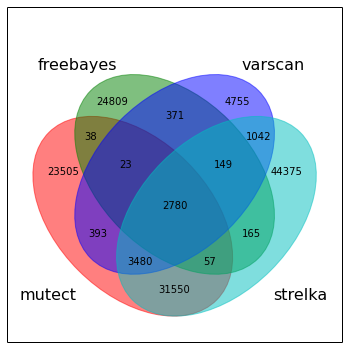

In [15]:
vn.venn([snpdf[snpdf.mutectallele != '']['chromPos'], \
         snpdf[snpdf.strelkaallele != '']['chromPos'], \
        snpdf[snpdf.freebayesallele != '']['chromPos'], \
        snpdf[snpdf.varscanallele != '']['chromPos'] \
        ],['mutect','strelka','freebayes','varscan'],figsize=(6,6))

### <hd3> Indel Venn

In [ ]:
indeldf= dfSlice[(dfSlice.variantType == 'INDEL')]

In [ ]:
vn.venn([indeldf[indeldf.strelkaallele != '']['chromPos'], \
        indeldf[indeldf.freebayesallele != '']['chromPos'], \
        indeldf[indeldf.varscanallele != '']['chromPos'] \
        ],['strelka','freebayes','varscan'],figsize=(6,6))

<h3> Allelic Depth

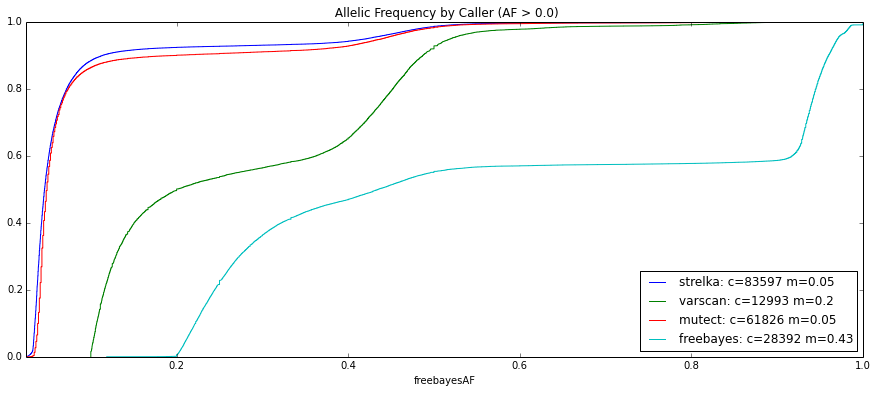

In [16]:
#Alllele Freq By Caller
for columnName in list(snpdf):
    if columnName.endswith('allele'):
        ser = snpdf[(snpdf[columnName] != '') &(snpdf[columnName[:-6] + 'AF'] > 0.0)][columnName[:-6] + 'AF']
        ser = ser.sort_values()
        #ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
        ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller (AF > 0.0)",figsize=[15,6])

In [ ]:
# BY CALLER BY TRUTH
truths = snpdf.Truth.unique()
for truth in truths:
    for columnName in list(snpdf):
        if columnName.endswith('allele'):
            ser = snpdf[(snpdf.Truth == truth) &(snpdf[columnName] != '')][columnName[:-6] + 'allelicFreq']
            ser = ser.sort_values()
            #ser[len(ser)] = ser.iloc[-1]
            cum_dist = np.linspace(0.,1.,len(ser))
            ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+" "+str(truth)+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
            ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller and Truth",figsize=[15,6])

In [ ]:
#  BY VENN SEGMENT - Single Caller - FALSE POSITIVES
myCaller = 'freebayes'
vennSegments = snpdf[(snpdf[myCaller+'allele'] != '') & (snpdf.Truth == False)].vennSegment.unique()
for vennSegment in vennSegments:
    ser = snpdf[(snpdf.vennSegment == vennSegment) & (snpdf[myCaller+'allele'] != '') & (snpdf.Truth == False) ][myCaller+'allelicFreq']
    ser = ser.sort_values()
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=vennSegment+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=myCaller+" FP by Venn Segment",figsize=[15,6])

### Allelic Depth Scatter Plot

In [ ]:
caller1 = 'varscan'
caller2 = 'strelka'
tempdf = df[(df[caller1+'allele']!='')&(df[caller2+'allele']!='')]
tempdf.head()
tempdf.plot.scatter(caller1+'allelicFreq',caller2+'allelicFreq' \
                        ,figsize=[6,6] \
                        ,title="Comparison of "+caller1+" and "+caller2+" Allelic Frequency" \
                        ,xlim=[0,1],ylim=[0,1])

<h3> RAINBOW CHARTS

In [ ]:
## RAINBOW
caller = 'freebayes'
plt.scatter(df[(df[caller+'allele']!='')& (df['Truth'] == True)&(df['chrom'] == '22')]['chromFrac'], \
            df[(df[caller+'allele']!='')& (df['Truth'] == True)&(df['chrom'] == '22')][caller+'allelicFreq'], \
            s=10, c='b', marker="s")

In [ ]:
## RAINBOW
caller = 'freebayes'
plt.scatter(df[(df[caller+'allele']!='')& (df['Truth'] == False)&(df['chrom'] == '22')]['chromFrac'], \
            df[(df[caller+'allele']!='')& (df['Truth'] == False)&(df['chrom'] == '22')][caller+'allelicFreq'], \
            s=10, c='b', marker="s")

<h3> Overlapping Analysis

In [ ]:
#NEEDS REFACTORING TO SUPPORT NEW DF FORMAT
'''
sorteddf = df.sort(['chromFrac'], ascending=1)
sorteddf['nextRef'] = sorteddf['ref'].shift(-2)
sorteddf['nextPos'] = sorteddf['pos'].shift(-2)
sorteddf['nextChrom'] = sorteddf['chrom'].shift(-2)
sorteddf['nextVT'] = sorteddf['variantType'].shift(-2)
sorteddf['nextAlleleTumor1'] = sorteddf['alleleTumor1'].shift(-2)
sorteddf['nextAlleleTumor2'] = sorteddf['alleleTumor2'].shift(-2)
sorteddf['nextVennSegment'] = sorteddf['vennSegment'].shift(-2)
sorteddf['lengthRef'] = sorteddf['ref'].str.len()
sorteddf['Dist2Next'] = -sorteddf['pos'].astype(int).diff(-2)

overlapdf = sorteddf[(sorteddf['lengthRef']+0>sorteddf['Dist2Next']) & (sorteddf['Dist2Next']>0)]
overlapdf.head(20)
'''

In [ ]:
#NEEDS REFACTORING TO SUPPORT NEW DF FORMAT
'''
filtereddf = overlapdf[(~overlapdf.vennSegment.isin(['freebayes','varscan','strelka1'])) \
                       & (overlapdf.vennSegment.str.contains('varscan')) \
                       #& (~overlapdf.nextVennSegment.str.contains('varscan')) \
                       & (overlapdf.variantType == 'INDEL') \
                       #& (overlapdf.variantSubType == 'DELETE')
                       & (overlapdf.variantType == overlapdf.nextVT)]
filtereddf[['nextVennSegment','vennSegment','variantType','nextVT','Dist2Next','lengthRef','ref','alleleTumor2', \
            'nextRef','nextAlleleTumor2','variantSubType','chrom','pos']].count()
'''